In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from tools import *
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
# import pandas as pd
import glob

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

In [4]:
conc_v_w_mol()


    c (mg/ml) 	 v% 	 w% 	 mol% 	 
    102         48.9 	 54.8 	 19.2
    135 	50.6 	 56.4 	 20.2
    314 	60.5 	 65.9 	 27.5
    SU13        55.0     60.7    23.2
    DLS         44.2     50.0    16.4
    


# Load data

In [5]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [6]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

In [7]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


In [8]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

**Ferritin XPCS**

In [9]:
Dc1 = np.load('../03-source/D_c1_240611.npz')
D_kww = np.load('../03-source/D_kww_241203.npz')
Dc1.files

['D', 'dD', 'T']

**Nanoparticles**

In [10]:
# constants
# Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
scale = 1e3
# R = 7.3e-9 # nm

kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9

# T_sel = 260

# Viscosity old processing

In [11]:
f = np.load("../03-source/viscosity_NP.npz") # 23 mol% = 50 w% = 44 v%
f_dls = np.load("../03-source/dls_NP_23mol.npz") # 23 mol% = 50 w% = 44 v%

el_to_remove = np.array([264])
f_dls_T = np.setdiff1d(f_dls['T'], el_to_remove)

f_dls_T_l = list(f_dls['T'])
f_dls_T_l.pop(1)
f_dls_T = np.array(f_dls_T_l)

f_dls_D_l = list(f_dls['D'])
f_dls_D_l.pop(1)
f_dls_D = np.array(f_dls_D_l)


f_dls_dD_l = list(f_dls['dD'])
f_dls_dD_l.pop(1)
f_dls_dD = np.array(f_dls_dD_l)

print(f_dls_T_l, f_dls_D, f_dls_dD)

[263.0, 268.0, 273.0, 278.0, 283.0, 288.0, 293.0, 298.0] [0.05664105 0.07665724 0.10912588 0.14275548 0.19238228 0.24220871
 0.30496679 0.37514384] [0.05664105 0.07665724 0.10912588 0.14275548 0.19238228 0.24220871
 0.30496679 0.37514384]


In [12]:
f_dls_T

array([263., 268., 273., 278., 283., 288., 293., 298.])

In [13]:
import scipy.interpolate

def log_interp1d(xx, yy, kind='linear'):

    result = np.where(yy > 0.0000000001, yy, -10)
    logy = np.log10(result, out=result, where=result > 0)

    logx = np.log10(xx)
    lin_interp = scipy.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))

    return log_interp


In [14]:
f.files

['T_np', 'eta_np', 'T_gly', 'eta_gly']

In [15]:
def viscosity_predic(T, w=0.5):
    " this is valid for w=0.5 from Gonzalez et al J. Chem. Eng. Data 2011, 56, 1397–1406"
    if w == 0.5:
        eta0 = np.exp(-1.183)*1e-3
        # eta0 = 1e-3*10**(-1.183)
        alpha=3.843
        Tg=160
    elif w == 0.6:
        eta0 = np.exp(-0.923)*1e-3 #Pa s, 
        # eta0 = 1e-3*10**(-0.923)#Pa s, 
        alpha = 3.863
        Tg=165.1
    
    eta = eta0 * np.exp( (28.75 - np.log(eta0)) * (Tg / T)**alpha ) # 
    return eta

[270.] [0.03399274]
Mass fraction of mixture = [0.61716051 0.61459263 0.61216732 0.60989039 0.60776967 0.60581616
 0.60404646 0.60355515 0.60278178 0.60248984 0.60207306 0.60145558
 0.60096275 0.60054475 0.60018778 0.59988519]
Volume fraction of mixture = 0.5429713457683679


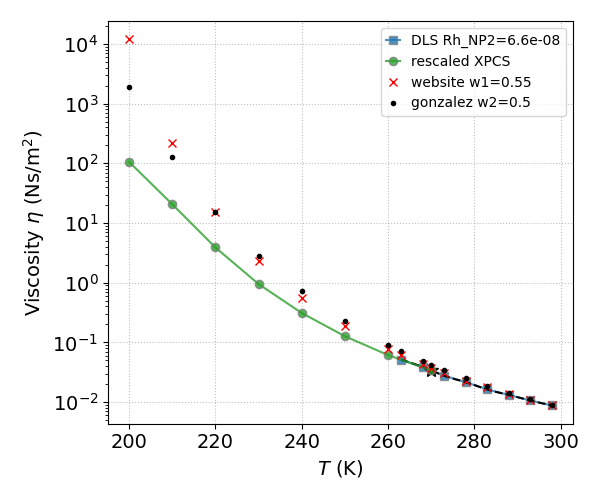

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

# -- From NP
# NP XPS data from viscosity_NP.npz 
# ax.plot(f['T_np'][1:], f['eta_np'][1:], label='XPCS', c='C2', mec='gray', alpha=0.8, marker='x')

# DLS NP100nm 23m/ol%
Rh_NP2 = 66e-9 # like in sharon's PCCP
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP2 * f_dls_D*1e-12) # change Rh
ax.plot(f_dls_T, eta_dls, label=f'DLS {Rh_NP2=}', c='C0', mec='gray', alpha=0.8, marker='s')#, mfc='none')

# interpolate
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
ax.plot(new_x, lin_interp(new_x), 'k--')

mask = (new_x == f['T_np'][-1])
plt.plot(new_x[mask], lin_interp(new_x)[mask], ls='', marker='*', c='k', ms=10)
print(new_x[mask], lin_interp(new_x)[mask])

# rescale
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]
ax.plot(f['T_np'][1:], f['eta_np'][1:]*fact, label='rescaled XPCS', c='C2', mec='gray', alpha=0.8, marker='o')

all_T = np.array([200., 210., 220., 230., 240., 250., 260., 263., 268., 270., 273., 278., 283., 288., 293., 298.])
# From tabulated values
w1 = 0.55
eta_anita = viscosity_glywater(T=all_T-273, weight_percent=0.6)
plt.plot(all_T, eta_anita, ls='', marker='x', c='r', label=f'website {w1=}')

# Gonzalez et al 2011
w2 = 0.5
eta_new = viscosity_predic(T=all_T, w=w2)
plt.plot(all_T, eta_new, ls='', marker='.', c='k', label=f'gonzalez {w2=}')


# w2 = 0.6
# eta_new2 = viscosity_predic(T=all_T, w=w2)# eta0=np.exp(-0.923)*1e-3, alpha = 3.863, Tg=165.1)
# plt.plot(all_T, eta_new2, ls='', marker='s', c='k', label=f'gonzalez {w2=}')


# plt.plot(all_T, viscosity_predic_fit(all_T, *popt), ls='-', c='r', label=f'fit')


# -- plot settings
ax.set_ylabel("Viscosity $\eta$ (Ns/m$^2$)")
ax.set_xlabel("$T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
# ax.set_xlim(240,300)
# ax.set_ylim(0.01,0.1)
plt.tight_layout()

In [17]:
data_tab = new_viscosity()
np.shape(data_tab)

(23, 2)

In [18]:
np.exp(-1.183)*1e-3

0.00030635828375793366

Mass fraction of mixture = [0.60776967 0.60581616 0.60404646 0.60355515 0.60278178 0.60248984
 0.60207306 0.60145558 0.60096275 0.60054475 0.60018778 0.59988519]
Volume fraction of mixture = 0.5429713457683679
[  0.42250929   4.09574954 162.31276136] [0.09801342 0.13343839 0.85926812]


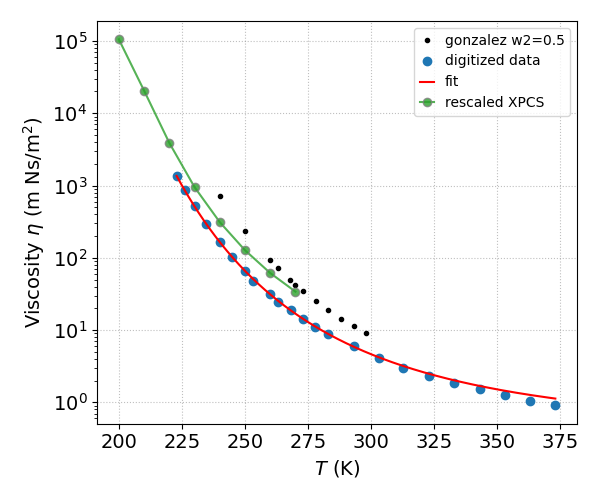

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)

all_T = np.array([240., 250., 260., 263., 268., 270., 273., 278., 283., 288., 293., 298.])
# From tabulated values
w1 = 0.55
eta_anita = viscosity_glywater(T=all_T-273, weight_percent=0.6)
# plt.plot(all_T, eta_anita, ls='', marker='x', c='r', label=f'website {w1=}')

# Gonzalez et al 2011
w2 = 0.5
eta_new = viscosity_predic(T=all_T, w=w2)
plt.plot(all_T, eta_new*1e3 , ls='', marker='.', c='k', label=f'gonzalez {w2=}')


plt.plot(data_tab[:,0], 10**data_tab[:,1], marker='o', ls='', label='digitized data')
# viscosity_predic(T, eta0, alpha, Tg):
popt_eta, xc, curve, perr = fit(viscosity_predic_fit, data_tab[:,0], 10**data_tab[:,1], p0=[3e-4, 3.8, 160],  bounds=[(0,0,100), (1, 10, 250)])
print(popt_eta, perr)
plt.plot(xc, curve, label='fit', c='r')

# -- xpcs
plt.plot(f['T_np'][1:], f['eta_np'][1:]*fact *1e3, label='rescaled XPCS', c='C2', mec='gray', alpha=0.8, marker='o')


# -- plot settings
ax.set_ylabel("Viscosity $\eta$ (m Ns/m$^2$)")
ax.set_xlabel("$T$ (K)")
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
# ax.set_xlim(230,300)
# ax.set_ylim(0., 50)
plt.tight_layout()

# Fit viscosities from paper

In [20]:
def viscosity_fit_params(w_wish=0.64, plot=True, title=None):
    """ Fits the viscosity from Fig 8 in Gozalez et al, J. Chem. Eng. Data 2011, 56, 1397–1406, weight% 0.5,0.6,0.7.
        The fit of the viscosity is done with eq 16 in the paper.
        Returns the fitting parameters for the desired weight%
    """
    # import data from Fig. 8. The viscosity values is actually np.log10(eta), that'w why we take 10**eta afterwords
    data_tab = new_viscosity() # w=0.5
    data_tab60 = new_viscosity_60() # w=0.6
    data_tab70 = new_viscosity_70() # w=0.7

    Ts = np.arange(210,380,5)
    ws = np.array([0.5, 0.6, 0.7])

    eta0s, alphas, Tgs = np.zeros(3), np.zeros(3), np.zeros(3) # w
    deta0s, dalphas, dTgs = np.zeros(3), np.zeros(3), np.zeros(3) # w

    # w = 0.5
    popt_eta1, xc, curve, perr1 = fit(viscosity_predic_fit, data_tab[:,0], 10**data_tab[:,1], sigma=10**data_tab[:,1] * 0.05, p0=[3e-4, 3.8, 160],  bounds=[(0,0,100), (1, 10, 250)])
    eta0s[0], alphas[0], Tgs[0] = popt_eta1
    deta0s[0], dalphas[0], dTgs[0] = perr1

    # w = 0.6
    popt_eta2, xc, curve, perr2 = fit(viscosity_predic_fit, data_tab60[:,0], 10**data_tab60[:,1], sigma=10**data_tab60[:,1] * 0.05, p0=[3e-4, 3.8, 160],  bounds=[(0,0,100), (1, 10, 250)])
    eta0s[1], alphas[1], Tgs[1] = popt_eta2
    deta0s[1], dalphas[1], dTgs[1] = perr2

    # w = 0.7
    popt_eta3, xc, curve, perr3 = fit(viscosity_predic_fit, data_tab70[:,0], 10**data_tab70[:,1], sigma=10**data_tab70[:,1] * 0.05, p0=[3e-4, 3.8, 160],  bounds=[(0,0,100), (1, 10, 250)])
    eta0s[2], alphas[2], Tgs[2] = popt_eta3
    deta0s[2], dalphas[2], dTgs[2] = perr3


    if plot:
        fig, ax = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
        fig5, (a3,a4,a5) = plt.subplots(1,3, figsize=(9,3), tight_layout=True)
        # w = 0.5
        ax.plot(data_tab[:,0], 10**data_tab[:,1], marker='s', ls='', c='C0', label='w=0.5', alpha=0.7)
        ax.plot(Ts, viscosity_predic_fit(Ts, *popt_eta1), c='C0', lw=1, alpha=0.7)
        # w = 0.6
        ax.plot(data_tab60[:,0], 10**data_tab60[:,1], marker='s', ls='', c='C1', label='w=0.6', alpha=0.7)
        ax.plot(Ts, viscosity_predic_fit(Ts, *popt_eta2), c='C1', lw=1, alpha=0.7)
        # w = 0.7
        ax.plot(data_tab70[:,0], 10**data_tab70[:,1] , marker='o', ls='', label='w=0.7', alpha=0.7, c='C2')
        ax.plot(Ts, viscosity_predic_fit(Ts, *popt_eta3), c='C2', lw=1, alpha=0.7)


    # -- fitting parameters plot
    # w_wish = 0.64
    z1 = np.polyfit(ws[1:], eta0s[1:], 1)
    z2 = np.polyfit(ws[1:], alphas[1:], 1)
    z3 = np.polyfit(ws, Tgs, 1)
    
    eta0_star = z1[0] * w_wish + z1[1]
    alpha_star = z2[0] * w_wish + z2[1]
    Tg_star = z3[0] * w_wish + z3[1]

    if plot:
        a3.errorbar(ws, eta0s, deta0s,  ls='', marker='o', c='r')
        a4.errorbar(ws, alphas, dalphas,  ls='', marker='o', c='r')
        a5.errorbar(ws, Tgs, dTgs,  ls='', marker='o', c='r')
    
        a5.errorbar(ws, z3[0] * ws + z3[1],  ls='-', c='gray', zorder=1)
        a5.plot(w_wish,  Tg_star, ls='', marker='*', c='k', ms=7, zorder=10)

        a4.errorbar(ws[1:], z2[0] * ws[1:] + z2[1],  ls='-', c='gray', zorder=1)
        a4.plot(w_wish, alpha_star, ls='', marker='*', c='k', ms=7, zorder=10)
        
        a3.errorbar(ws[1:], z1[0] * ws[1:] + z1[1],  ls='-', c='gray', zorder=1)
        a3.plot(w_wish,  eta0_star, ls='', marker='*', c='k', ms=7, zorder=10)

        ax.plot(Ts,  viscosity_predic_fit(Ts, eta0_star, alpha_star, Tg_star), ls='--', c='k', lw=1, alpha=0.7, label=f'w={w_wish:.2f}')

        # -- plot settings
        ax.set_ylabel("Viscosity $\eta$ (m Ns/m$^2$)")
        ax.set_xlabel("$T$ (K)")
        ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
        ax.set_yscale('log')
        a3.set_ylabel(r"$\eta_0$")
        a4.set_ylabel(r"$\alpha$")
        a5.set_ylabel(r"$T_g$ (K)")
        a3.set_xlabel("weight fraction")
        a4.set_xlabel("weight fraction")
        a5.set_xlabel("weight fraction")
        fig5.suptitle("fitting parameters")
        if title:
            ax.set_title(title)
        plt.tight_layout()
        
    return eta0_star, alpha_star, Tg_star


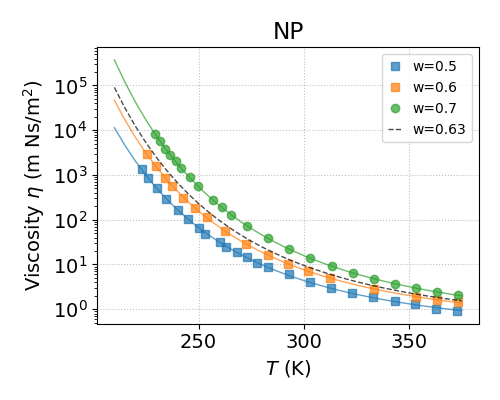

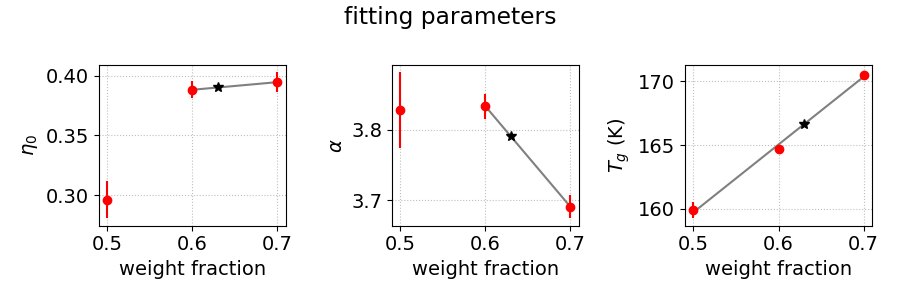

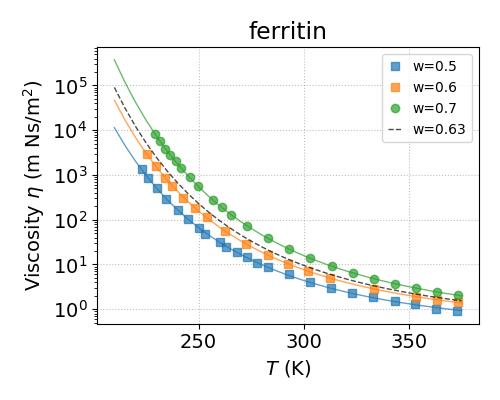

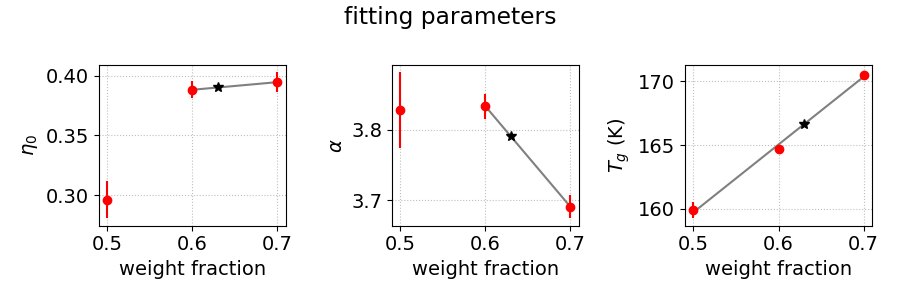

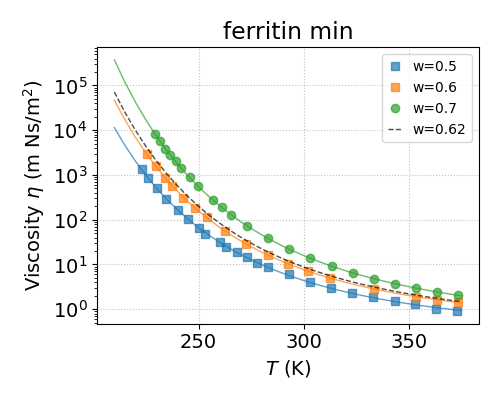

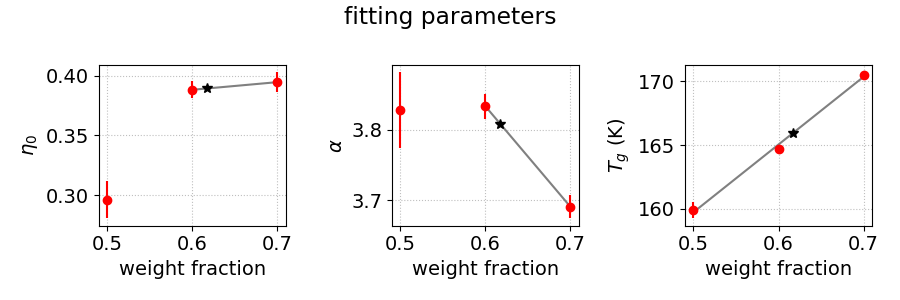

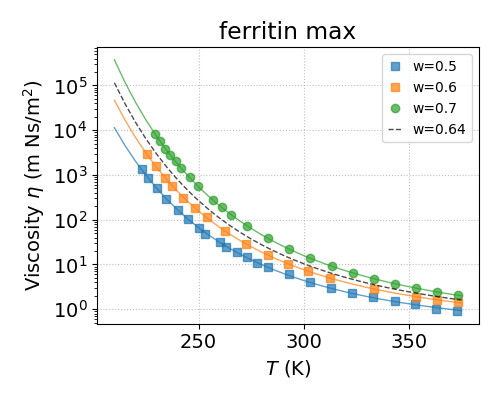

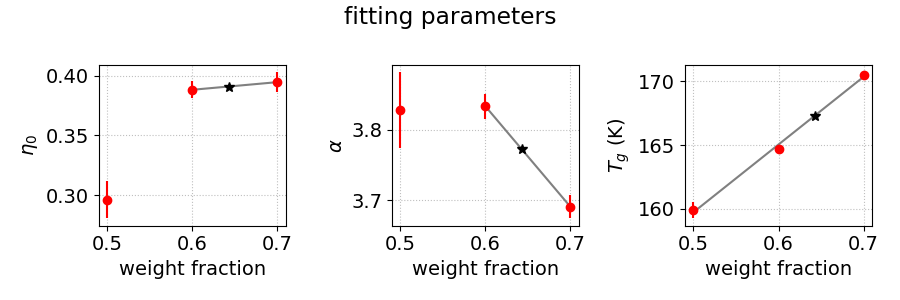

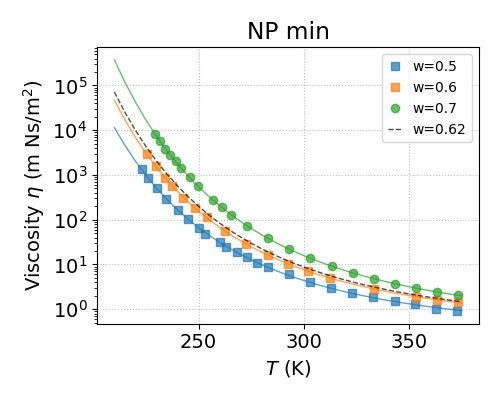

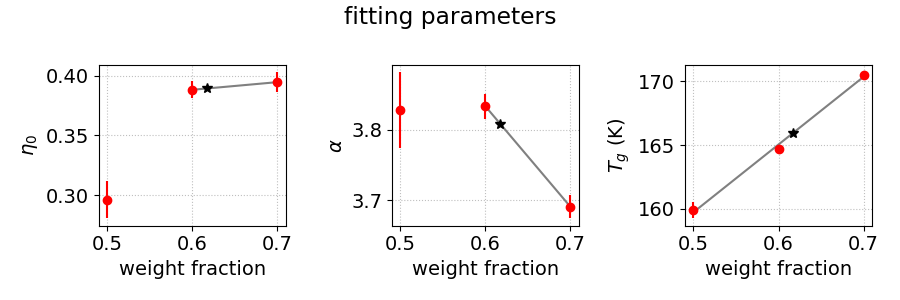

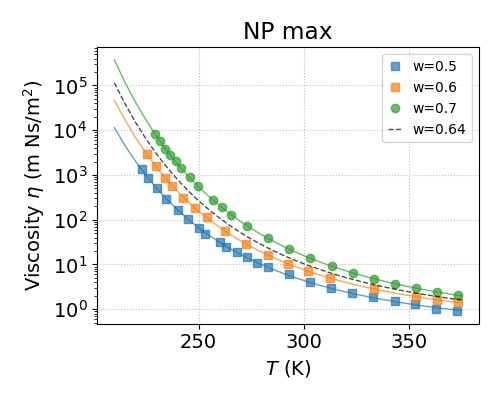

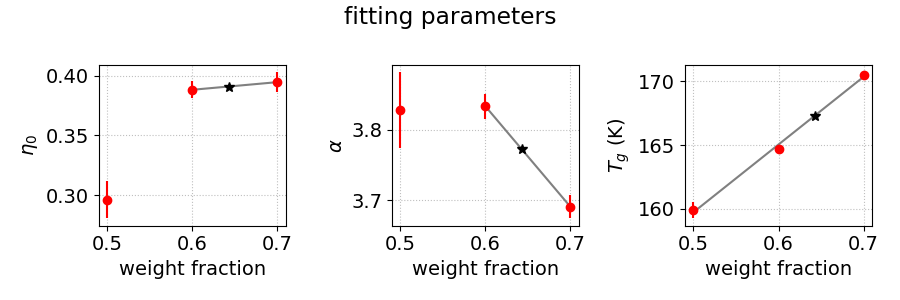

In [21]:
w_NP, w_fer = 0.63, 0.63

fit_par_NP = viscosity_fit_params(w_wish=w_NP, plot=True, title='NP')
fit_par_fer = viscosity_fit_params(w_wish=w_fer, plot=True, title='ferritin')

fit_par_fer_min = viscosity_fit_params(w_wish=w_fer-w_fer*0.02, plot=True, title='ferritin min')
fit_par_fer_max = viscosity_fit_params(w_wish=w_fer+w_fer*0.02, plot=True, title='ferritin max')

fit_par_NP_min = viscosity_fit_params(w_wish=w_fer-w_fer*0.02, plot=True, title='NP min')
fit_par_NP_max = viscosity_fit_params(w_wish=w_fer+w_fer*0.02, plot=True, title='NP max')

In [22]:
alp = 3.6344 + 1.2198*w_fer - 1.6142*w_fer
alp

3.385928

In [23]:
x_SE = np.arange(200,310,10)

eta_DLS_ = [ viscosity_predic_fit(T, *fit_par_NP) * 1e-3 for T in f_dls_T ]
eta_xpcs_ = [ viscosity_predic_fit(T, *fit_par_NP)* 1e-3 for T in f['T_np'][1:] ]

# eta_xpcs_min = [ viscosity_predic_fit(T, *fit_par_fer_min)* 1e-3 for T in f['T_np'][1:] ]
# eta_xpcs_max = [ viscosity_predic_fit(T, *fit_par_fer_max)* 1e-3 for T in f['T_np'][1:] ]

eta_SE = [ viscosity_predic_fit(T, *fit_par_fer) * 1e-3 for T in x_SE ]
eta_ferr = [ viscosity_predic_fit(T, *fit_par_fer) * 1e-3 for T in Dc1['T'] ]

# eta_ferr_min = [ viscosity_predic_fit(T, *fit_par_fer_min) * 1e-3 for T in Dc1['T'] ]
# eta_ferr_max = [ viscosity_predic_fit(T, *fit_par_fer_max) * 1e-3 for T in Dc1['T'] ]


# Plot

In [24]:
# -- factor to rescale DLS/xpcs
# DLS NP100nm 23m/ol%
Rh_NP2 = 66e-9 # like in sharon's PCCP
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12)
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP2 * f_dls_D*1e-12) # change Rh
ax.plot(f_dls_T, eta_dls, label=f'DLS {Rh_NP2=}', c='C0', mec='gray', alpha=0.8, marker='s')#, mfc='none')

# interpolate
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
ax.plot(new_x, lin_interp(new_x), 'k--')

mask = (new_x == f['T_np'][-1])
plt.plot(new_x[mask], lin_interp(new_x)[mask], ls='', marker='*', c='k', ms=10)
print(new_x[mask], lin_interp(new_x)[mask])

# rescale
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

[270.] [0.03399274]


VFT NP [ 5.18160890e+04 -1.11787007e+01  1.23055418e+02] [2.37471357e+04 1.27984593e+00 4.39478499e+00]
VFT ferritin [ 6.64251627e+05 -2.57073136e+01  8.57747672e+01] [7.07651481e+05 7.92945143e+00 1.27937698e+01]
SE:  [ 7.69575771e+04 -9.98768779e+00  1.33911464e+02] [1.51407973e+04 4.14253235e-01 1.47709852e+00]

Avg first values of DLS:  0.9376336835000038

Deviation ferritin:  210 8.96427517124677

Deviation NP:  210 3.4525703931324103
Using viscosities for w_NP=0.63 and w_fer=0.63


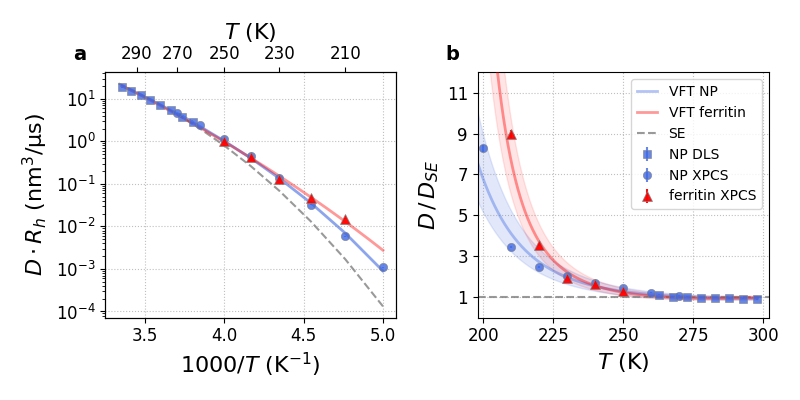

In [25]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(8,4), tight_layout=True)

correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m
norm = kb / (6*np.pi)

NP_xpcs_T = f['T_np'][1:]
NP_xpcs_D =  kb * f['T_np'][1:] / (6*np.pi * f['eta_np'][1:] / fact * Rh_NP) #* fact

# -- PANEL A
a1.errorbar(scale/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, f_dls_dD * 1e-12 * Rh_NP * correct_unit * 0.02,  label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=12)
# a1.plot(scale/NP_xpcs_T, NP_xpcs_D * Rh_NP * correct_unit, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)
a1.errorbar(scale/NP_xpcs_T, NP_xpcs_D * Rh_NP * correct_unit, NP_xpcs_D * Rh_NP * correct_unit * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=13)
a1.errorbar(scale/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', label='ferritin', zorder=14)
# a1.errorbar(scale/D_kww['T'], D_kww['D']*1e-12 * Rh * correct_unit, D_kww['dD']*1e-12 * Rh * correct_unit, marker='x', ms=7, c='k', ls='')

# VFT NP
fit_x = np.concatenate([NP_xpcs_T, f_dls_T])
fit_y = np.concatenate([NP_xpcs_D * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt_NP,xc_NP,curve_NP,perr_NP = fit(VFT, fit_x, fit_y, sigma=fit_y*0.02, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 200)]) # VFT(x, a, D, T0)
a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='-', c='royalblue', alpha=0.6, lw=2, label='VFT NP', zorder=1)
print(f"VFT NP", popt_NP, perr_NP)

Tll = np.linspace(195, np.max(f_dls_T), 1000)
VFT_eta2 = viscosity_predic_fit(Tll, *fit_par_NP)*1e-3
a2.plot(Tll, VFT(Tll, *popt_NP) * VFT_eta2 / Tll / norm / correct_unit, ls='-', c='royalblue', lw=2, alpha=0.4, label='VFT NP', zorder=2)


VFT_eta2_min = viscosity_predic_fit(Tll, *fit_par_NP_min)*1e-3
VFT_eta2_max = viscosity_predic_fit(Tll, *fit_par_NP_max)*1e-3
a2.fill_between(Tll, VFT(Tll, *popt_NP) * VFT_eta2_min / Tll / norm / correct_unit, VFT(Tll, *popt_NP) * VFT_eta2_max / Tll / norm / correct_unit, alpha=0.15,  color='royalblue', )

# VFT NP + protein XPCS
fit_x = np.concatenate([Dc1['T'][::-1], f_dls_T])
fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
fit_dy = np.concatenate([Dc1['dD'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit * 0.02])

popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_dy, p0=[100, -1., 100], bounds=[(0,-np.infty,10), (np.infty,0,200)]) # VFT(x, a, D, T0) 
Tl = np.linspace(200, np.max(f_dls_T), 1000)
a1.plot(scale/Tl, VFT(Tl, *popt_p), ls='-', c='r', lw=2, alpha=0.4, label='VFT ferritin', zorder=10)
VFT_eta = viscosity_predic_fit(Tl, *fit_par_fer)*1e-3
a2.plot(Tl, VFT(Tl, *popt_p) * VFT_eta / Tl / norm / correct_unit, ls='-', c='r', lw=2, alpha=0.4, label='VFT ferritin', zorder=3)
print(f"VFT ferritin", popt_p, perr_p)

VFT_eta_min = viscosity_predic_fit(Tl, *fit_par_fer_min)*1e-3
VFT_eta_max = viscosity_predic_fit(Tl, *fit_par_fer_max)*1e-3
a2.fill_between(Tl, VFT(Tl, *popt_p) * VFT_eta_min / Tl / norm / correct_unit, VFT(Tl, *popt_p) * VFT_eta_max / Tl / norm / correct_unit, alpha=0.1,  color='r', )

# VFT SE
y_SE = np.array([ kb * x_SE[i] / (6*np.pi * Rh * eta_SE[i]) for i in range(len(x_SE))])
a1.plot(scale/x_SE,  y_SE * Rh * correct_unit, c='gray', ls='--', alpha=0.8, label='SE', zorder=0)
popt, xc, curve, perr = fit(VFT, x_SE, y_SE * Rh * correct_unit, sigma=y_SE*0.02, p0=[100, -1., 100], bounds=[(0,-np.infty,10), (np.infty,0,200)])
print("SE: ", popt, perr)

VFT_eta_SE = viscosity_predic_fit(Tl, *fit_par_fer)*1e-3
# a1.plot(scale/xc, curve, ls=':', c='r', lw=1, alpha=0.8, label='VFT SE', zorder=3)


###### PANEL B
# NP_xpcs_T = f['T_np'][1:]
# NP_xpcs_D =  kb * f['T_np'][1:] / (6*np.pi * f['eta_np'][1:] * fact * Rh_NP)


# -- SE
y_SE = np.array([ kb * x_SE[i] / (6*np.pi * Rh * eta_SE[i]) for i in range(len(x_SE))])
# y_SE = kb * x_SE / (6*np.pi * Rh * eta_SE)
# a2.plot(x_SE,  y_SE * Rh * eta_SE / x_SE / norm,  c='gray', ls=':', alpha=0.8, label='SE', zorder=0)
a2.axhline(y=1, ls='--', c='gray', alpha=0.8, label='SE')

# -- experimental data
# DLS
a2.errorbar(f_dls_T, f_dls_D*1e-12 * Rh_NP * eta_DLS_ / f_dls_T / norm,  f_dls_D*1e-12 * Rh_NP * eta_DLS_ / f_dls_T / norm * 0.02, label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=12)
# NP XPCS
a2.errorbar(NP_xpcs_T,  NP_xpcs_D * Rh_NP * eta_xpcs_/ NP_xpcs_T / norm, NP_xpcs_D * Rh_NP * eta_xpcs_ / NP_xpcs_T / norm * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=13)
# ferritin
a2.errorbar(Dc1['T'],  Dc1['D']*1e-12 * Rh * eta_ferr / Dc1['T'] / norm, yerr =  Dc1['dD']*1e-12 * Rh * eta_ferr / Dc1['T'] / norm, marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', label='ferritin XPCS', zorder=14)
print("\nAvg first values of DLS: ", np.mean(f_dls_D[3:]*1e-12 * Rh_NP * eta_DLS_[3:] / f_dls_T[3:] / norm))

print("\nDeviation ferritin: ", Dc1['T'][-1],  Dc1['D'][-1]*1e-12 * Rh * eta_ferr[-1] / Dc1['T'][-1] / norm)
print("\nDeviation NP: ", NP_xpcs_T[1],   NP_xpcs_D[1] * Rh_NP * eta_xpcs_[1]/ NP_xpcs_T[1] / norm)

# -- plot settings
# a2.set_ylabel("$D\cdot R_h \cdot  \eta\,/\,T$", fontsize=16)
a2.set_ylabel("$D\,/\,D_{SE}$", fontsize=16)
a2.set_xlabel("$T$ (K)", fontsize=16)
# a2.legend(handlelength=1, fontsize=11)
a2.tick_params(axis='both', which='major', labelsize=12)
a2.set_yticks(np.arange(1,12,2))
a2.set_ylim(0,12)
a2.set_xlim(198, 302)

# -- plot settings
a1.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a1.set_xlabel("$1000/T$ (K$^{-1}$)", fontsize=16)
a1.set_yscale('log')
a1.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

a1.text(-0.11, 1.05, 'a', fontweight='bold', transform=a1.transAxes)
a2.text(-0.11, 1.05, 'b', fontweight='bold', transform=a2.transAxes)
# a1.legend(handlelength=1, fontsize=10, ncol=1, frameon=True)
a2.legend(handlelength=1.5, fontsize=10, ncol=1, frameon=True)

print(f"Using viscosities for {w_NP=} and {w_fer=}")

**The following shows that the best weight% to use is 64%, at least for NP**

In [26]:
wws = [0.65, 0.64, 0.63]
avg = [1.09372, 1.01216, 0.9376]

for i in range(len(avg)):
    print(wws[i], f"{abs(1-avg[i]):.2f}")


0.65 0.09
0.64 0.01
0.63 0.06


## fractional SE

VFT NP [ 5.18160890e+04 -1.11787007e+01  1.23055418e+02] [2.37471357e+04 1.27984593e+00 4.39478499e+00]
VFT ferritin [ 6.64251627e+05 -2.57073136e+01  8.57747672e+01] [7.07651481e+05 7.92945143e+00 1.27937698e+01]
SE:  [ 7.69575771e+04 -9.98768779e+00  1.33911464e+02] [1.51407973e+04 4.14253235e-01 1.47709852e+00]

Avg first values of DLS:  0.9376336835000038

Deviation ferritin:  210 8.96427517124677

Deviation NP:  210 3.4525703931324103
fSE NP:  [-0.82937968 -5.67102621] [0.00765432 0.0589633 ]
Using viscosities for w_NP=0.63 and w_fer=0.63


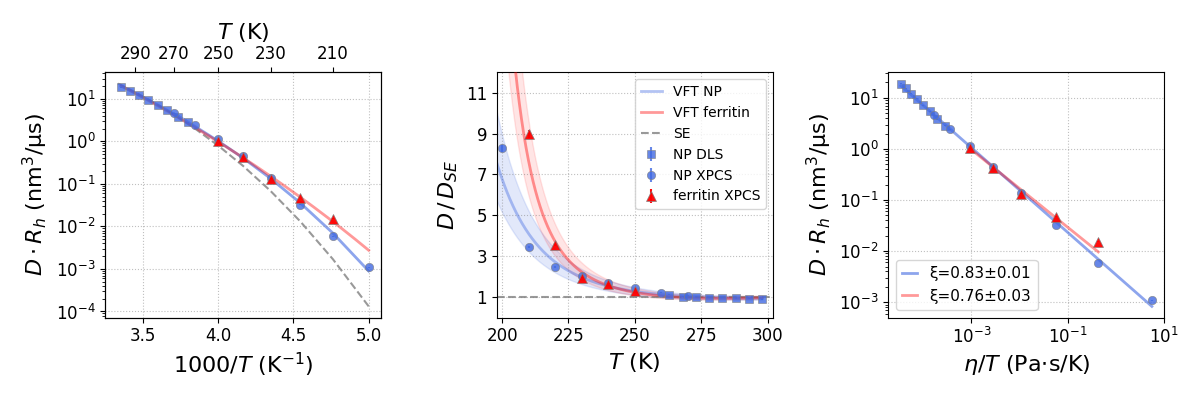

In [27]:
fig, (a1,a2,a3) = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m
norm = kb / (6*np.pi)

NP_xpcs_T = f['T_np'][1:]
NP_xpcs_D =  kb * f['T_np'][1:] / (6*np.pi * f['eta_np'][1:] / fact * Rh_NP) #* fact

# -- PANEL A
a1.errorbar(scale/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, f_dls_dD * 1e-12 * Rh_NP * correct_unit * 0.02,  label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=12)
# a1.plot(scale/NP_xpcs_T, NP_xpcs_D * Rh_NP * correct_unit, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)
a1.errorbar(scale/NP_xpcs_T, NP_xpcs_D * Rh_NP * correct_unit, NP_xpcs_D * Rh_NP * correct_unit * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=13)
a1.errorbar(scale/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', label='ferritin', zorder=14)

# VFT NP
fit_x = np.concatenate([NP_xpcs_T, f_dls_T])
fit_y = np.concatenate([NP_xpcs_D * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt_NP,xc_NP,curve_NP,perr_NP = fit(VFT, fit_x, fit_y, sigma=fit_y*0.02, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 200)]) # VFT(x, a, D, T0)
a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='-', c='royalblue', alpha=0.6, lw=2, label='VFT NP', zorder=1)
print(f"VFT NP", popt_NP, perr_NP)

Tll = np.linspace(195, np.max(f_dls_T), 1000)
VFT_eta2 = viscosity_predic_fit(Tll, *fit_par_NP)*1e-3
a2.plot(Tll, VFT(Tll, *popt_NP) * VFT_eta2 / Tll / norm / correct_unit, ls='-', c='royalblue', lw=2, alpha=0.4, label='VFT NP', zorder=2)


VFT_eta2_min = viscosity_predic_fit(Tll, *fit_par_NP_min)*1e-3
VFT_eta2_max = viscosity_predic_fit(Tll, *fit_par_NP_max)*1e-3
a2.fill_between(Tll, VFT(Tll, *popt_NP) * VFT_eta2_min / Tll / norm / correct_unit, VFT(Tll, *popt_NP) * VFT_eta2_max / Tll / norm / correct_unit, alpha=0.15,  color='royalblue', )

# VFT NP + protein XPCS
fit_x = np.concatenate([Dc1['T'][::-1], f_dls_T])
fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
fit_dy = np.concatenate([Dc1['dD'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit * 0.02])

popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_dy, p0=[100, -1., 100], bounds=[(0,-np.infty,10), (np.infty,0,200)]) # VFT(x, a, D, T0) 
Tl = np.linspace(200, np.max(f_dls_T), 1000)
a1.plot(scale/Tl, VFT(Tl, *popt_p), ls='-', c='r', lw=2, alpha=0.4, label='VFT ferritin', zorder=10)
VFT_eta = viscosity_predic_fit(Tl, *fit_par_fer)*1e-3
a2.plot(Tl, VFT(Tl, *popt_p) * VFT_eta / Tl / norm / correct_unit, ls='-', c='r', lw=2, alpha=0.4, label='VFT ferritin', zorder=3)
print(f"VFT ferritin", popt_p, perr_p)

VFT_eta_min = viscosity_predic_fit(Tl, *fit_par_fer_min)*1e-3
VFT_eta_max = viscosity_predic_fit(Tl, *fit_par_fer_max)*1e-3
a2.fill_between(Tl, VFT(Tl, *popt_p) * VFT_eta_min / Tl / norm / correct_unit, VFT(Tl, *popt_p) * VFT_eta_max / Tl / norm / correct_unit, alpha=0.1,  color='r', )

# VFT SE
y_SE = np.array([ kb * x_SE[i] / (6*np.pi * Rh * eta_SE[i]) for i in range(len(x_SE))])
a1.plot(scale/x_SE,  y_SE * Rh * correct_unit, c='gray', ls='--', alpha=0.8, label='SE', zorder=0)
popt, xc, curve, perr = fit(VFT, x_SE, y_SE * Rh * correct_unit, sigma=y_SE*0.02, p0=[100, -1., 100], bounds=[(0,-np.infty,10), (np.infty,0,200)])
print("SE: ", popt, perr)

VFT_eta_SE = viscosity_predic_fit(Tl, *fit_par_fer)*1e-3
# a1.plot(scale/xc, curve, ls=':', c='r', lw=1, alpha=0.8, label='VFT SE', zorder=3)


###### PANEL B
# NP_xpcs_T = f['T_np'][1:]
# NP_xpcs_D =  kb * f['T_np'][1:] / (6*np.pi * f['eta_np'][1:] * fact * Rh_NP)


# -- SE
y_SE = np.array([ kb * x_SE[i] / (6*np.pi * Rh * eta_SE[i]) for i in range(len(x_SE))])
# y_SE = kb * x_SE / (6*np.pi * Rh * eta_SE)
# a2.plot(x_SE,  y_SE * Rh * eta_SE / x_SE / norm,  c='gray', ls=':', alpha=0.8, label='SE', zorder=0)
a2.axhline(y=1, ls='--', c='gray', alpha=0.8, label='SE')

# -- experimental data
# DLS
a2.errorbar(f_dls_T, f_dls_D*1e-12 * Rh_NP * eta_DLS_ / f_dls_T / norm,  f_dls_D*1e-12 * Rh_NP * eta_DLS_ / f_dls_T / norm * 0.02, label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=12)
# NP XPCS
a2.errorbar(NP_xpcs_T,  NP_xpcs_D * Rh_NP * eta_xpcs_/ NP_xpcs_T / norm, NP_xpcs_D * Rh_NP * eta_xpcs_ / NP_xpcs_T / norm * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=13)
# ferritin
a2.errorbar(Dc1['T'],  Dc1['D']*1e-12 * Rh * eta_ferr / Dc1['T'] / norm, yerr =  Dc1['dD']*1e-12 * Rh * eta_ferr / Dc1['T'] / norm, marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', label='ferritin XPCS', zorder=14)
print("\nAvg first values of DLS: ", np.mean(f_dls_D[3:]*1e-12 * Rh_NP * eta_DLS_[3:] / f_dls_T[3:] / norm))
print("\nDeviation ferritin: ", Dc1['T'][-1],  Dc1['D'][-1]*1e-12 * Rh * eta_ferr[-1] / Dc1['T'][-1] / norm)
print("\nDeviation NP: ", NP_xpcs_T[1],   NP_xpcs_D[1] * Rh_NP * eta_xpcs_[1]/ NP_xpcs_T[1] / norm)


# -- fractional SE
# DLS
a3.errorbar(eta_DLS_/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit,  f_dls_D*1e-12 * Rh_NP * 0.02 * correct_unit, c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=12) # label='NP DLS',
# NP XPCS
a3.errorbar(eta_xpcs_/NP_xpcs_T,  NP_xpcs_D * Rh_NP * correct_unit, NP_xpcs_D * Rh_NP * 0.02 * correct_unit, ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=13) #  label='NP XPCS',
# ferritin
a3.errorbar(eta_ferr/Dc1['T'],  Dc1['D']*1e-12 * Rh * correct_unit, yerr =  Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', zorder=14) #label='ferritin XPCS',


# -- fit NP
x_NP = np.concatenate([eta_xpcs_/NP_xpcs_T, eta_DLS_/f_dls_T])
y_NP = np.concatenate([NP_xpcs_D * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt,xc,curve,perr = fit(linear_q, np.log(x_NP), np.log(y_NP), p0=[1.,1.])
a3.plot(np.exp(xc), np.exp(curve), ls='-', c='royalblue', alpha=0.6, lw=2,  label=f'ξ={-popt[0]:.2f}±{perr[0]:.2f}')
print("fSE NP: ", popt, perr)


# -- fit ferritin
x_ferr = np.concatenate([ eta_DLS_/f_dls_T, eta_ferr/Dc1['T']])
y_ferr = np.concatenate([f_dls_D*1e-12 * Rh_NP * correct_unit, Dc1['D']*1e-12 * Rh * correct_unit])

x_ferr = np.concatenate([eta_ferr/Dc1['T']])
y_ferr = np.concatenate([Dc1['D']*1e-12 * Rh * correct_unit])

popt,xc,curve,perr = fit(linear_q, np.log(x_ferr), np.log(y_ferr), sigma=np.log(y_ferr)*0.01, p0=[1.,1.])
a3.plot(np.exp(xc), np.exp(curve),  ls='-', c='r', lw=2, alpha=0.4, label= f'ξ={-popt[0]:.2f}±{perr[0]:.2f}')



# -- plot settings
# a2.set_ylabel("$D\cdot R_h \cdot  \eta\,/\,T$", fontsize=16)
a2.set_ylabel("$D\,/\,D_{SE}$", fontsize=16)
a2.set_xlabel("$T$ (K)", fontsize=16)
# a2.legend(handlelength=1, fontsize=11)
a2.tick_params(axis='both', which='major', labelsize=12)
a2.set_yticks(np.arange(1,12,2))
a2.set_ylim(0,12)
a2.set_xlim(198, 302)

# -- plot settings
a1.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a1.set_xlabel("$1000/T$ (K$^{-1}$)", fontsize=16)
a1.set_yscale('log')
a1.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

a3.set_xlabel("$\eta/T$ (Pa$\cdot$s/K)", fontsize=16)
a3.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a3.legend(handlelength=1, loc='lower left', fontsize=11)
a3.set_yscale('log')
a3.set_xscale('log')
a3.tick_params(axis='both', which='major', labelsize=12)


# a1.text(-0.11, 1.05, 'a', fontweight='bold', transform=a1.transAxes)
# a2.text(-0.11, 1.05, 'b', fontweight='bold', transform=a2.transAxes)
# a3.text(-0.11, 1.05, 'c', fontweight='bold', transform=a3.transAxes)
# a1.legend(handlelength=1, fontsize=10, ncol=1, frameon=True)
a2.legend(handlelength=1.5, fontsize=10, ncol=1, frameon=True)

print(f"Using viscosities for {w_NP=} and {w_fer=}")

In [28]:
fig, (a1,a2,a3) = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m
norm = kb / (6*np.pi)

NP_xpcs_T = f['T_np'][1:]
NP_xpcs_D =  kb * f['T_np'][1:] / (6*np.pi * f['eta_np'][1:] / fact * Rh_NP) #* fact

# -- PANEL A
a1.errorbar(scale/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, f_dls_dD * 1e-12 * Rh_NP * correct_unit * 0.02,  label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=12)
# a1.plot(scale/NP_xpcs_T, NP_xpcs_D * Rh_NP * correct_unit, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)
a1.errorbar(scale/NP_xpcs_T, NP_xpcs_D * Rh_NP * correct_unit, NP_xpcs_D * Rh_NP * correct_unit * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=13)
a1.errorbar(scale/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', label='ferritin', zorder=14)

# VFT NP
fit_x = np.concatenate([NP_xpcs_T, f_dls_T])
fit_y = np.concatenate([NP_xpcs_D * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt_NP,xc_NP,curve_NP,perr_NP = fit(VFT, fit_x, fit_y, sigma=fit_y*0.02, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 200)]) # VFT(x, a, D, T0)
a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='-', c='royalblue', alpha=0.6, lw=2, label='VFT NP', zorder=1)
print(f"VFT NP", popt_NP, perr_NP)

Tll = np.linspace(195, np.max(f_dls_T), 1000)
VFT_eta2 = viscosity_predic_fit(Tll, *fit_par_NP)*1e-3
a2.plot(Tll, VFT(Tll, *popt_NP) * VFT_eta2 / Tll / norm / correct_unit, ls='-', c='royalblue', lw=2, alpha=0.4, label='VFT NP', zorder=2)


VFT_eta2_min = viscosity_predic_fit(Tll, *fit_par_NP_min)*1e-3
VFT_eta2_max = viscosity_predic_fit(Tll, *fit_par_NP_max)*1e-3
a2.fill_between(Tll, VFT(Tll, *popt_NP) * VFT_eta2_min / Tll / norm / correct_unit, VFT(Tll, *popt_NP) * VFT_eta2_max / Tll / norm / correct_unit, alpha=0.15,  color='royalblue', )

# VFT NP + protein XPCS
fit_x = np.concatenate([Dc1['T'][::-1], f_dls_T])
fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
fit_dy = np.concatenate([Dc1['dD'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit * 0.02])

popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_dy, p0=[100, -1., 100], bounds=[(0,-np.infty,10), (np.infty,0,200)]) # VFT(x, a, D, T0) 
Tl = np.linspace(200, np.max(f_dls_T), 1000)
a1.plot(scale/Tl, VFT(Tl, *popt_p), ls='-', c='r', lw=2, alpha=0.4, label='VFT ferritin', zorder=10)
VFT_eta = viscosity_predic_fit(Tl, *fit_par_fer)*1e-3
a2.plot(Tl, VFT(Tl, *popt_p) * VFT_eta / Tl / norm / correct_unit, ls='-', c='r', lw=2, alpha=0.4, label='VFT ferritin', zorder=3)
print(f"VFT ferritin", popt_p, perr_p)

VFT_eta_min = viscosity_predic_fit(Tl, *fit_par_fer_min)*1e-3
VFT_eta_max = viscosity_predic_fit(Tl, *fit_par_fer_max)*1e-3
a2.fill_between(Tl, VFT(Tl, *popt_p) * VFT_eta_min / Tl / norm / correct_unit, VFT(Tl, *popt_p) * VFT_eta_max / Tl / norm / correct_unit, alpha=0.1,  color='r', )

# VFT SE
y_SE = np.array([ kb * x_SE[i] / (6*np.pi * Rh * eta_SE[i]) for i in range(len(x_SE))])
a1.plot(scale/x_SE,  y_SE * Rh * correct_unit, c='gray', ls='--', alpha=0.8, label='SE', zorder=0)
popt, xc, curve, perr = fit(VFT, x_SE, y_SE * Rh * correct_unit, sigma=y_SE*0.02, p0=[100, -1., 100], bounds=[(0,-np.infty,10), (np.infty,0,200)])
print("SE: ", popt, perr)

VFT_eta_SE = viscosity_predic_fit(Tl, *fit_par_fer)*1e-3
# a1.plot(scale/xc, curve, ls=':', c='r', lw=1, alpha=0.8, label='VFT SE', zorder=3)



# -- SE
y_SE = np.array([ kb * x_SE[i] / (6*np.pi * Rh * eta_SE[i]) for i in range(len(x_SE))])
# y_SE = kb * x_SE / (6*np.pi * Rh * eta_SE)
# a2.plot(x_SE,  y_SE * Rh * eta_SE / x_SE / norm,  c='gray', ls=':', alpha=0.8, label='SE', zorder=0)
a2.axhline(y=1, ls='--', c='gray', alpha=0.8, label='SE')

# -- experimental data
# # DLS
# a2.errorbar(f_dls_T, f_dls_D*1e-12 * Rh_NP * eta_DLS_ / f_dls_T / norm,  f_dls_D*1e-12 * Rh_NP * eta_DLS_ / f_dls_T / norm * 0.02, label='NP DLS', c='royalblue', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=12)
# # NP XPCS
# a2.errorbar(NP_xpcs_T,  NP_xpcs_D * Rh_NP * eta_xpcs_/ NP_xpcs_T / norm, NP_xpcs_D * Rh_NP * eta_xpcs_ / NP_xpcs_T / norm * 0.02, label='NP XPCS', ls='', c='royalblue', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=13)
# # ferritin
norm = 
a2.errorbar(Dc1['T'],  Dc1['D']*1e-12 * Rh * eta_ferr / Dc1['T'] / norm, yerr =  Dc1['dD']*1e-12 * Rh * eta_ferr / Dc1['T'] / norm, marker='^', ms=7, c='r', ls='', mew=.5,  alpha=0.95, mec='gray', label='ferritin XPCS', zorder=14)



print("\nAvg first values of DLS: ", np.mean(f_dls_D[3:]*1e-12 * Rh_NP * eta_DLS_[3:] / f_dls_T[3:] / norm))
print("\nDeviation ferritin: ", Dc1['T'][-1],  Dc1['D'][-1]*1e-12 * Rh * eta_ferr[-1] / Dc1['T'][-1] / norm)
print("\nDeviation NP: ", NP_xpcs_T[1],   NP_xpcs_D[1] * Rh_NP * eta_xpcs_[1]/ NP_xpcs_T[1] / norm)



# -- plot settings
# a2.set_ylabel("$D\cdot R_h \cdot  \eta\,/\,T$", fontsize=16)
a2.set_ylabel("$D\,/\,D_{SE}$", fontsize=16)
a2.set_xlabel("$T$ (K)", fontsize=16)
# a2.legend(handlelength=1, fontsize=11)
a2.tick_params(axis='both', which='major', labelsize=12)
a2.set_yticks(np.arange(1,12,2))
a2.set_ylim(0,12)
a2.set_xlim(198, 302)

# -- plot settings
a1.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a1.set_xlabel("$1000/T$ (K$^{-1}$)", fontsize=16)
a1.set_yscale('log')
a1.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

a3.set_xlabel("$\eta/T$ (Pa$\cdot$s/K)", fontsize=16)
a3.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a3.legend(handlelength=1, loc='lower left', fontsize=11)
a3.set_yscale('log')
a3.set_xscale('log')
a3.tick_params(axis='both', which='major', labelsize=12)


# a1.text(-0.11, 1.05, 'a', fontweight='bold', transform=a1.transAxes)
# a2.text(-0.11, 1.05, 'b', fontweight='bold', transform=a2.transAxes)
# a3.text(-0.11, 1.05, 'c', fontweight='bold', transform=a3.transAxes)
# a1.legend(handlelength=1, fontsize=10, ncol=1, frameon=True)
a2.legend(handlelength=1.5, fontsize=10, ncol=1, frameon=True)

print(f"Using viscosities for {w_NP=} and {w_fer=}")

SyntaxError: invalid syntax (3349111123.py, line 73)

### Linear temperature axis

Text(-0.15, 1.05, 'a')

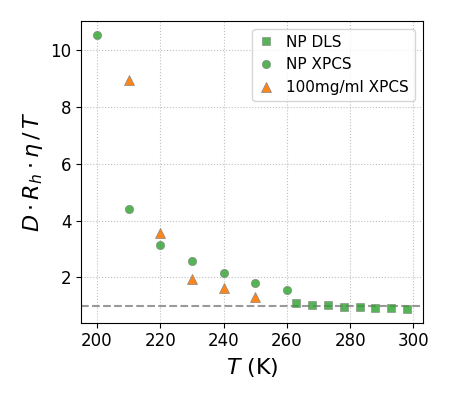

In [30]:
fig, a2 = plt.subplots(1,1, figsize=(4.5,4), tight_layout=True)
# inset
# a1 = a3.inset_axes([.53, .15, .45, .45])

correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m

# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

# arrays to use
# diffusion coefficient DLS
# DLS NP: f_dls_T, f_dls_D*1e12, f_dls_dD
# XPCS NP: f['T_np'][1:], f['eta_np'] * fact 
# NP_xpcs_T = f['T_np'][1:]
# NP_xpcs_D =  kb * f['T_np'][1:] / (6*np.pi * f['eta_np'][1:] * fact * Rh_NP)
# ferritin: Dc1['T'], Dc1['D']*1e-12, Dc1['dD']*1e-12


NP_xpcs_T = f['T_np'][1:]
NP_xpcs_D =  kb * f['T_np'][1:] / (6*np.pi * f['eta_np'][1:] * fact * Rh_NP)

norm = kb / (6*np.pi)

# -- SE
y_SE = np.array([ kb * x_SE[i] / (6*np.pi * Rh * eta_SE[i]) for i in range(len(x_SE))])
# y_SE = kb * x_SE / (6*np.pi * Rh * eta_SE)
# a2.plot(x_SE,  y_SE * Rh * eta_SE / x_SE / norm,  c='gray', ls=':', alpha=0.8, label='SE', zorder=0)
a2.axhline(y=1, ls='--', c='gray', alpha=0.8)

# -- experimental data
# DLS
a2.plot(f_dls_T, f_dls_D*1e-12 * Rh_NP * eta_DLS_ / f_dls_T / norm, label='NP DLS', c='C2', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=2)

# NP XPCS
a2.plot(NP_xpcs_T[:-1],  NP_xpcs_D[:-1] * Rh_NP * eta_xpcs_[:-1] / NP_xpcs_T[:-1] / norm, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)

# ferritin
a2.plot(Dc1['T'],  Dc1['D']*1e-12 * Rh * eta_ferr / Dc1['T'] / norm, marker='^', ms=7, c='C1', ls='', mew=.5,  alpha=0.95, mec='gray', label='100mg/ml XPCS', zorder=4)



# -- plot settings
a2.set_ylabel("$D\cdot R_h \cdot  \eta\,/\,T$", fontsize=16)
a2.set_xlabel("$T$ (K)", fontsize=16)
a2.legend(handlelength=1, fontsize=11)
a2.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)

a1.text(-0.15, 1.05, 'a', fontweight='bold', transform=a1.transAxes)

# a2.text(0.7, 0.1, f'$\xi$=1.02', transform=a2.transAxes, fontsize=11)

# Complete figure

Arrhenius DLS: -33.67 pm 0.77
Arrhenius XPCS NP: -61.52 pm 0.60
Arrhenius ferritin: -46.34 pm 0.95
[200. 210. 220. 230. 240. 250. 260. 270. 263. 268. 273. 278. 283. 288.
 293. 298.]
VFT NP: 122 pm 4
B:  1411.6778631088405
VFT prot: 102 pm 9
B:  1786.8288657392302
Exponent (NP): 1.02 pm 0.01
Exponent (protein): -0.807 pm 0.04


Text(0.7, 0.1, '$\\xi$=1.02')

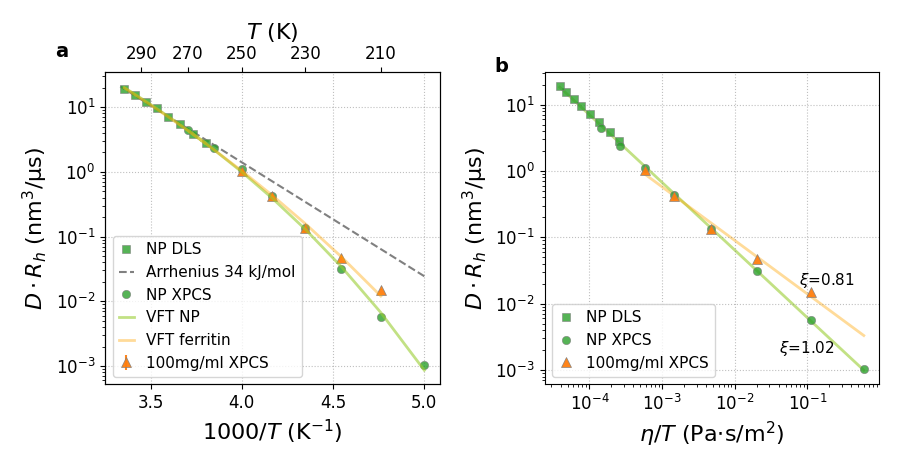

In [31]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(9,4.7), tight_layout=True)
# inset
# a1 = a3.inset_axes([.53, .15, .45, .45])

correct_unit = 1e21 # go from m3/s to nm3/us
kb = 1.380649e-23 # m2 kg s-2 K-1
Rh = 7.3e-9 # m
Rh_NP = 50e-9 # m
eta_dls = f_dls_T * kb / (6*np.pi* Rh_NP * f_dls_D*1e-12) # Ns/m2
# rescaling factor for eta 23mol% NP
lin_interp = scipy.interpolate.interp1d(f_dls_T, eta_dls, kind='quadratic')
new_x = np.arange(f_dls_T[0], f_dls_T[-1]+1, 1)
mask = (new_x == f['T_np'][-1])
fact = lin_interp(new_x)[mask] / f['eta_np'][-1]

###### PANEL A
# -- dls
a1.plot(scale/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, label='NP DLS', c='C2', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=2)
popt1,xc,curve1,perr1 = fit(arrhenius, f_dls_T,  f_dls_D*1e-12 * Rh_NP * correct_unit, p0=[1e7, -4e3])
# print("DLS NP: ", popt1)
Ea1, dEa1 = popt1[1] * kb / 1e3 * Na, perr1[1] * kb / 1e3 * Na
dls_ex_T = np.arange(200, 301, 10)
a1.plot(scale/dls_ex_T, arrhenius(dls_ex_T, *popt1), ls='--', c='gray', label=f'Arrhenius {-Ea1:.0f} kJ/mol', zorder=1)
print(f"Arrhenius DLS: {Ea1:.2f} pm {dEa1:.2f}")

# -- NP xpcs
SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
a1.plot(scale/f['T_np'][1:], SE[1: ] * Rh_NP * correct_unit, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)
popt2,xc,curve2,perr2 = fit(arrhenius, f['T_np'][1:-4], SE[1:-4] * Rh_NP * correct_unit, p0=[4e9, -5e3])
Ea2, dEa2 = popt2[1] * kb / 1e3 * Na, perr2[1] * kb / 1e3 * Na
# a1.plot(scale/f['T_np'][1:-1], arrhenius(f['T_np'][1:-1], *popt2), ls='--', c='k', label=f'XPCS {Ea2:.2f} pm {dEa2:.2f}')
print(f"Arrhenius XPCS NP: {Ea2:.2f} pm {dEa2:.2f}")

# -- ferritin
a1.errorbar(scale/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, Dc1['dD']*1e-12 * Rh * correct_unit, marker='^', ms=7, c='C1', ls='', mew=.5,  alpha=0.95, mec='gray', label='100mg/ml XPCS', zorder=4)
popt,xc,curve,perr = fit(arrhenius, Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, sigma=Dc1['dD']*1e-12 * Rh * correct_unit,  p0=[4e9, -5e3])  
Ea, dEa = popt[1] * kb / 1e3 * Na, perr[1] * kb / 1e3 * Na
# a1.plot(scale/Dc1['T'], arrhenius(Dc1['T'], *popt), ls='-', c='C1', label=f'prot {Ea:.2f} pm {dEa:.2f}')
print(f"Arrhenius ferritin: {Ea:.2f} pm {dEa:.2f}")

# -- VFT
fit_x = np.concatenate([f['T_np'][1:], f_dls_T])
print(fit_x)
fit_y = np.concatenate([ SE[1: ] * Rh_NP * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
popt_NP,xc_NP,curve_NP,perr_NP = fit(VFT, fit_x, fit_y, sigma=fit_y*0.01, p0=[100, -1., 160], bounds=[(0,-np.infty,0), (np.infty, 0, 200)]) # VFT(x, a, D, T0)
# a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='--', c='k', label='VFT NP', zorder=10)
a1.plot(scale/fit_x, VFT(fit_x, *popt_NP), ls='-', c='yellowgreen', alpha=0.6, lw=2, label='VFT NP', zorder=10)

print(f"VFT NP: {popt_NP[-1]:.0f} pm {perr_NP[-1]:.0f}")
print("B: ", -popt_NP[1]*popt_NP[2])

# -- VFT fit NP + protein XPCS
fit_x = np.concatenate([Dc1['T'][::-1], f_dls_T])
fit_y = np.concatenate([Dc1['D'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit])
fit_dy = np.concatenate([Dc1['dD'][::-1]*1e-12 * Rh * correct_unit, f_dls_D*1e-12 * Rh_NP * correct_unit*0.01])

popt_p,xc_p,curve_p,perr_p = fit(VFT, fit_x, fit_y, sigma=fit_dy, p0=[100, -1., 110], bounds=[(0,-np.infty,100), (np.infty,0,200)]) # VFT(x, a, D, T0) 
# popt_p2,xc_p2,curve_p2,perr_p2 = fit(VFT, Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit, sigma=fit_dy, p0=[100, -1., 110], bounds=[(0,-np.infty,100), (np.infty,0,200)]) # VFT(x, a, D, T0) 

# a1.plot(scale/fit_x, VFT(fit_x, *popt_p), ls=':', c='k', label='VFT ferritin', zorder=10)
a1.plot(scale/fit_x, VFT(fit_x, *popt_p), ls='-', c='orange', lw=2, alpha=0.4, label='VFT ferritin', zorder=10)
print(f"VFT prot: {popt_p[-1]:.0f} pm {perr_p[-1]:.0f}")

print("B: ", -popt_p[1]*popt_p[2])


###### PANEL B
# -- DLS NP100nm 23m/ol%
x_NP = np.concatenate([f_dls_T/eta_dls, f['T_np'][1:]/f['eta_np'][1:]])
x_NP2 = np.concatenate([f_dls_T, f['T_np'][1:]])
y_NP = np.concatenate([f_dls_D*1e-12 * Rh_NP, SE[1:] * Rh_NP])

a2.plot(eta_dls/f_dls_T, f_dls_D*1e-12 * Rh_NP * correct_unit, label='NP DLS', c='C2', mec='gray', ls='', alpha=0.8, mew=.5, marker='s', zorder=2)

# -- NP xpcs
SE = kb * f['T_np'] / (6*np.pi * f['eta_np'] * fact * Rh_NP)
a2.plot(f['eta_np'][1:]/f['T_np'][1:], SE[1: ] * Rh_NP * correct_unit, label='NP XPCS', ls='', c='C2', mec='gray', alpha=0.8, marker='o', mew=.5, zorder=3)

# -- fit NP
popt,xc,curve,perr = fit(linear_q, np.log(x_NP), np.log(y_NP), p0=[1.,1.])
# a2.plot(1/np.exp(xc), np.exp(curve) * correct_unit , '-k', zorder=1, lw=1)
a2.plot(1/np.exp(xc), np.exp(curve) * correct_unit , ls='-', c='yellowgreen', lw=2, alpha=0.6, zorder=1)
print(f"Exponent (NP): {popt[0]:.2f} pm {perr[0]:.2f}")

# -- xpcs c1 in 19 mol%
etas = np.array([f['eta_np'][f['T_np'] == t][0] for t in Dc1['T'] ]) #Ns/m
a2.plot(etas/Dc1['T'], Dc1['D']*1e-12 * Rh * correct_unit,  marker='^', ms=7, c='C1', ls='', mew=.5,  alpha=0.95, mec='gray', label='100mg/ml XPCS', zorder=4)

# protein fit
x_pr = np.concatenate([eta_dls/f_dls_T, etas/Dc1['T']])
y_pr = np.concatenate([f_dls_D*1e-12 * Rh_NP, Dc1['D']*1e-12 * Rh])
popt2,xc2,curve2,perr2 = fit(linear_q, np.log(etas/Dc1['T']), np.log(Dc1['D']*1e-12 * Rh), sigma=np.log(Dc1['D']*1e-12)*0.01, p0=[1.,1.])
# a2.plot(np.exp(xc2), np.exp(curve2) * correct_unit, ls=':', c='k', zorder=1)
print(f"Exponent (protein): { popt2[0]:.3f} pm {perr2[0]:.2f}")
# -- fit of ferritin, longer x axis
nnewx = np.linspace(np.min(np.log(etas/Dc1['T'])), np.log(f['eta_np'][1]/f['T_np'][1]), 100)
# a2.plot(np.exp(nnewx), np.exp(linear_q(nnewx, *popt2)) * correct_unit, ls=':', c='k', zorder=1)
a2.plot(np.exp(nnewx), np.exp(linear_q(nnewx, *popt2)) * correct_unit, ls='-', c='orange', alpha=0.4, lw=2, zorder=1)


# -- plot settings
a1.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a1.set_xlabel("$1000/T$ (K$^{-1}$)", fontsize=16)
a1.legend(handlelength=1, fontsize=11)
a1.set_yscale('log')
a1.tick_params(axis='both', which='major', labelsize=12)

ax1 = a1.twiny()
ax1.set_xlim(270,210)
ax1.set_xlim(a1.get_xlim())
ax1.set_xticks(scale/np.arange(210,300,20))
ax1.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax1.set_xlabel('$T$ (K)', fontsize=16)
ax1.grid(False)
ax1.tick_params(axis='both', which='major', labelsize=12)


a2.set_xlabel("$\eta/T$ (Pa$\cdot$s/m$^{2}$)", fontsize=16)
a2.set_ylabel("$D\cdot R_h$ (nm$^{{3}}$/${{\mathrm{\mu}}}$s)", fontsize=16)
a2.legend(handlelength=1, loc='lower left', fontsize=11)
a2.set_yscale('log')
a2.set_xscale('log')
a2.tick_params(axis='both', which='major', labelsize=12)

a1.text(-0.15, 1.05, 'a', fontweight='bold', transform=a1.transAxes)
a2.text(-0.15, 1, 'b', fontweight='bold', transform=a2.transAxes)

# a1.text(0.65, 0.95, 'Arrhenius', transform=a1.transAxes)
# a2.text(0.6, 0.9, 'Fractional SE', transform=a2.transAxes)
a2.text(0.76, 0.32, r'$\xi$=0.81', transform=a2.transAxes, fontsize=11)
a2.text(0.7, 0.1, r'$\xi$=1.02', transform=a2.transAxes, fontsize=11)
# plt.savefig('../06-figs/DRh_vs_etaT.png', dpi=300)